# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL


In [22]:
# load weekly sales dataset

filename = "../../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


# Data analysis

First, explore the time series.

## Plot time series

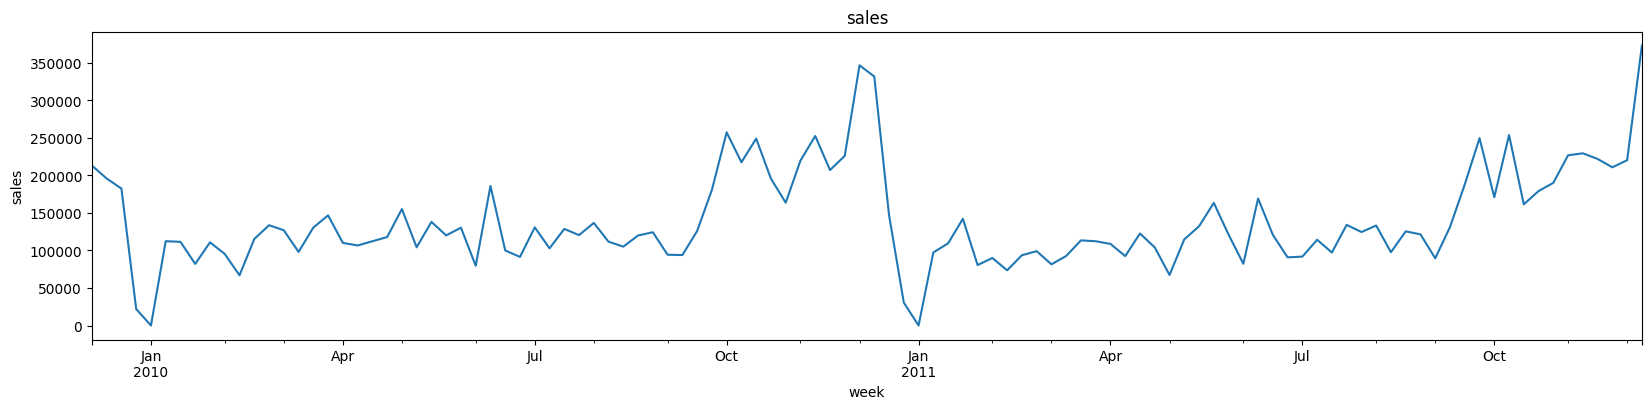

In [23]:
# Plot the time series.

for var in ["sales"]:

    # Plot the time series
    df[var].plot(figsize=(20, 4))

    # Add title
    plt.title(var)

    # the y axis label
    plt.ylabel(var)

    plt.show()


In [24]:
# check data index is in pandas date time format
df.index


DatetimeIndex(['2009-12-06', '2009-12-13', '2009-12-20', '2009-12-27',
               '2010-01-03', '2010-01-10', '2010-01-17', '2010-01-24',
               '2010-01-31', '2010-02-07',
               ...
               '2011-10-09', '2011-10-16', '2011-10-23', '2011-10-30',
               '2011-11-06', '2011-11-13', '2011-11-20', '2011-11-27',
               '2011-12-04', '2011-12-11'],
              dtype='datetime64[ns]', name='week', length=106, freq=None)

In [25]:
# Sanity check: data date span.

df.index.min(), df.index.max()


(Timestamp('2009-12-06 00:00:00'), Timestamp('2011-12-11 00:00:00'))

## Missing data

Check if there are missing values in the time series.

In [26]:
# Quick check: missing data.

df.isnull().sum()


sales    0
dtype: int64

## Missing timestamps

Check if there are missing timestamps in the index.

In [27]:
df.index.isnull().sum()

0

## Seasonality

Does the time series show any obvious seasonal pattern?

In [28]:
# December holiday spike in sales stands out. Let's check.

# Capture "month" in a new variable.

month_ = df.index.month

month_ = pd.Series(month_, index=df.index)

month_.head()


week
2009-12-06    12
2009-12-13    12
2009-12-20    12
2009-12-27    12
2010-01-03     1
Name: week, dtype: int32

Text(0, 0.5, 'Sales')

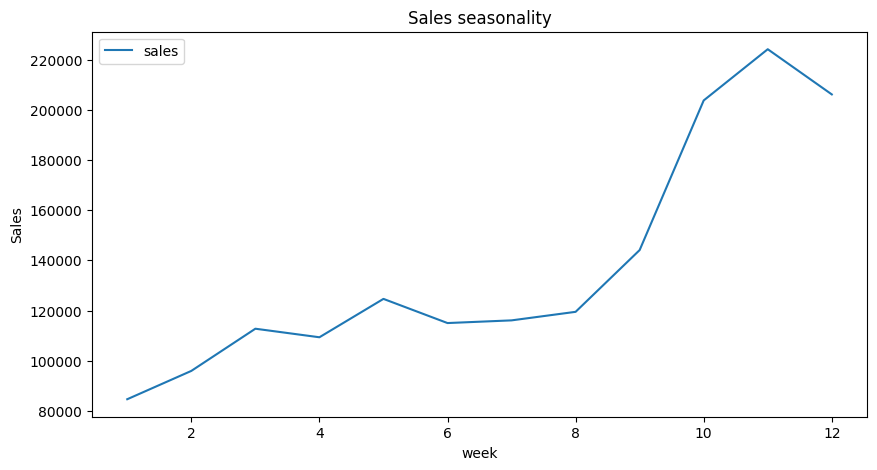

In [29]:
# Plot the average sales per month.

df.groupby(month_)[["sales"]].mean().plot(figsize=(10, 5))
plt.title("Sales seasonality")
plt.ylabel("Sales")


# Feature engineering

Now, let's begin to tabularize the data.

In [30]:
# Extract date and time features.

df["Month"] = df.index.month
df["Week"] = df.index.isocalendar().week

# Show new variables
df.head()


,sales,Month,Week
week,,,
2009-12-06,213000.35,12,49
2009-12-13,195810.04,12,50
2009-12-20,182396.74,12,51
2009-12-27,22007.77,12,52
2010-01-03,0.00,1,53


In [31]:
# We will use last week sales as well as 1 year ago week (52 weeks) sales as lag features

# raw time series
variables = ["sales"]

# Shift the data forward 1 Wk.
tmp = df[variables].shift(freq="1W")

# Names for the new variables.
tmp.columns = [v + "_lag_1w" for v in variables]

# Add the variables to the original data.
print("df size before")
print(df.shape)

df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("df size after")
print(df.shape)

df.head()


df size before
(106, 3)
df size after
(106, 4)


,sales,Month,Week,sales_lag_1w
week,,,,
2009-12-06,213000.35,12,49,NaN
2009-12-13,195810.04,12,50,213000.35
2009-12-20,182396.74,12,51,195810.04
2009-12-27,22007.77,12,52,182396.74
2010-01-03,0.00,1,53,22007.77


In [32]:

# raw time series
variables = ["sales"]

# Shift the data forward 1 Wk.
tmp = df[variables].shift(freq="52W")

# Names for the new variables.
tmp.columns = [v + "_lag_52w" for v in variables]

# Add the variables to the original data.
print("df size before")
print(df.shape)

df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("df size after")
print(df.shape)

df.head(100)


df size before
(106, 4)
df size after
(106, 5)


,sales,Month,Week,sales_lag_1w,sales_lag_52w
week,,,,,
2009-12-06,213000.350,12,49,NaN,NaN
2009-12-13,195810.040,12,50,213000.350,NaN
2009-12-20,182396.740,12,51,195810.040,NaN
2009-12-27,22007.770,12,52,182396.740,NaN
2010-01-03,0.000,1,53,22007.770,NaN
...,...,...,...,...,...
2011-10-02,170904.201,10,39,249563.051,257301.30
2011-10-09,253713.540,10,40,170904.201,217442.93
2011-10-16,161438.540,10,41,253713.540,248979.16


In [38]:
# In this procedure, we introduced missing
# data whenever there was no data available in
# the previous 1 and 52 weeks.

df.isnull().sum()


sales             0
Month             0
Week              0
sales_lag_1w      1
sales_lag_52w    52
dtype: int64

In [40]:
# Use the mean of the 3 previous weeks as input variables.

tmp = (
    df[variables]
    .rolling(window="21D")
    .mean()  # Average the last 3 hr values.
    .shift(freq="1W")  # Move the average 1 hour forward
)

# Rename the columns
tmp.columns = [v + "_window" for v in variables]


# view of the result
tmp.head(10)


,sales_window
week,
2009-12-13,213000.350000
2009-12-20,204405.195000
2009-12-27,197069.043333
2010-01-03,133404.850000
2010-01-10,68134.836667
2010-01-17,44775.540000
2010-01-24,74593.106667
2010-01-31,101948.217000
2010-02-07,101438.797333


In [42]:
# Join the new variables to the original data.
print("df size before")
print(df.shape)

df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("df size after")
print(df.shape)

df.head()


df size before
(106, 5)
df size after
(106, 6)


,sales,Month,Week,sales_lag_1w,sales_lag_52w,sales_window
week,,,,,,
2009-12-06,213000.35,12,49,NaN,NaN,NaN
2009-12-13,195810.04,12,50,213000.35,NaN,213000.350000
2009-12-20,182396.74,12,51,195810.04,NaN,204405.195000
2009-12-27,22007.77,12,52,182396.74,NaN,197069.043333
2010-01-03,0.00,1,53,22007.77,NaN,133404.850000


In [45]:
# Create features that capture the cyclical representation.
from feature_engine.creation import CyclicalFeatures
cyclical = CyclicalFeatures(
    variables=["Month"],  # The features we want to transform.
    drop_original=False,  # Whether to drop the original features.
)

df = cyclical.fit_transform(df)

df.head()

,sales,Month,Week,sales_lag_1w,sales_lag_52w,sales_window,Month_sin,Month_cos
week,,,,,,,,
2009-12-06,213000.35,12,49,NaN,NaN,NaN,-2.449294e-16,1.000000
2009-12-13,195810.04,12,50,213000.35,NaN,213000.350000,-2.449294e-16,1.000000
2009-12-20,182396.74,12,51,195810.04,NaN,204405.195000,-2.449294e-16,1.000000
2009-12-27,22007.77,12,52,182396.74,NaN,197069.043333,-2.449294e-16,1.000000
2010-01-03,0.00,1,53,22007.77,NaN,133404.850000,5.000000e-01,0.866025


In [47]:
# Determine fraction of missing data.

df.isnull().sum() / len(df)


sales            0.000000
Month            0.000000
Week             0.000000
sales_lag_1w     0.009434
sales_lag_52w    0.490566
sales_window     0.009434
Month_sin        0.000000
Month_cos        0.000000
dtype: float64

In [49]:
# drop missing data

print("df size before")
print(df.shape)

df.dropna(inplace=True)

print("data size after")
print(df.shape)

df.isnull().sum() / len(df)


df size before
(54, 8)
data size after
(54, 8)


sales            0.0
Month            0.0
Week             0.0
sales_lag_1w     0.0
sales_lag_52w    0.0
sales_window     0.0
Month_sin        0.0
Month_cos        0.0
dtype: float64

## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [33]:
# Find minimum and maximum dates.

df.index.min(), df.index.max()


(Timestamp('2009-12-06 00:00:00'), Timestamp('2011-12-11 00:00:00'))

In [34]:
# We will keep the last month of data to test
# the forecasting models.

X_train = df[df.index < "2011-10-01"]
X_test = df[df.index >= "2011-10-01"]

X_train.shape, X_test.shape


((95, 5), (11, 5))

In [35]:
# the target variable
y_train = X_train["sales"].copy()
y_test = X_test["sales"].copy()


## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

## Machine Learning

In [36]:
# Performance of naive forecast

print("train rmse: ", mean_squared_error(
    y_train, X_train["CO_sensor_lag_1"], squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, X_test["CO_sensor_lag_1"], squared=False,))


NameError: name 'mean_squared_error' is not defined